An Allen-Cahn playground
========================

This notebook will walk you through the front end of pySDC.
We will set up a problem that is already implemented with our custom parameters and we will configure the properties of SDC we want.
Then, we will pass the configuration to the controller and run our problem.
Before looking a bit more in the back end, we will shortly look at how to analyse and visualize the results.

A first SDC run
---------------

We will start by setting up our spatial problem:
A 2D non-linear reaction-diffusion equation that can be used to model phase-field transitions.
The equation reads
$$u_t = \Delta u + \frac{1}{\epsilon^2}u(1-u^\nu),$$
where we use finite differences for spatial discretization.

The phases are modelled as values close to 1 and values close to 0 in the solution.
As initial conditions, we choose a circle of the 1 phase embedded in the 0 phase, where the parameter $\epsilon$ models the width of the transition.

We also specify some tolerances.
Because the problem is non-linear, we employ a Newton solver, which wants a tolerance, but we abort after 100 iterations in case the solver does not converge.
In each Newton iteration, we are solving a linearized version of the problem, where a linear system of equations arises for us to solve.
For this we use a [conjugate gradient](<https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.cg.html>) implementation from scipy.

In [1]:
from pySDC.implementations.problem_classes.AllenCahn_2D_FD import allencahn_fullyimplicit

# initialize problem parameters
problem_params = dict()
problem_params['nu'] = 2
problem_params['eps'] = 0.04
problem_params['radius'] = 0.25
problem_params['nvars'] = [(128, 128)]
problem_params['newton_maxiter'] = 100
problem_params['newton_tol'] = 1E-08
problem_params['lin_tol'] = 1E-09
problem_params['lin_maxiter'] = 100

Next, we configure the temporal setup for pySDC.
The different parameters are spread between a variety of configuration dictionaries that may not seem straightforward at first sight.
Please bear with us!

We will divide the temporal domain in steps and solve them one at a time.
We will treat SDC as an iterative method and only losely restrict the number of iterations per step.

The tolerance for declaring convergence is, however, not a parameter of the step because pySDC supports multiple levels on each step which each can have a different tolerance.
We will not bother with this today, but know that this is the reasoning behind all the crucial parameters being parameters of the level instead of the step.

The sweeper is where the magic hapens.
SDC solves fully implicit Runge-Kutta methods iteratively, by performing sweeps with a preconditioner.
Unlike the collocation method, this is lower triangular, allowing us to solve each iteration with forward substitution.
The sweeper coordinates this by telling the problem class where to evaluate the right hand side in order to assemble "implicit Euler" steps that are also solved in the problem class.
We setup a particular collocation problem that we want to solve and a preconditioner that will be used in the iterations.
As initial guess, we just spread the initial conditions to all collocation nodes.

In [2]:
# initialize step parameters
step_params = dict()
step_params['maxiter'] = 50

# initialize level parameters
level_params = dict()
level_params['restol'] = 1E-07
level_params['dt'] = 1E-03 / 2
level_params['nsweeps'] = 1

# initialize sweeper parameters
sweeper_params = dict()
sweeper_params['quad_type'] = 'RADAU-RIGHT'
sweeper_params['QI'] = ['LU']
sweeper_params['num_nodes'] = 4
sweeper_params['initial_guess'] = 'spread'

# setup parameters "in time"
t0 = 0
Tend = 0.016

Finally, the controller.
This gathers all configurations and actually runs the problem we have set up.

In [3]:
from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI
from pySDC.implementations.sweeper_classes.generic_implicit import generic_implicit

# initialize controller parameters
controller_params = dict()
controller_params['logger_level'] = 20

# fill description dictionary for easy step instantiation
description = dict()
description['problem_class'] = allencahn_fullyimplicit
description['problem_params'] = problem_params
description['sweeper_class'] = generic_implicit
description['sweeper_params'] = sweeper_params
description['level_params'] = level_params
description['step_params'] = step_params

# instantiate controller
controller = controller_nonMPI(num_procs=1, controller_params=controller_params, description=description)

controller - INFO: Welcome to the one and only, really very astonishing and 87.3% bug free
                                 _____ _____   _____ 
                                / ____|  __ \ / ____|
                    _ __  _   _| (___ | |  | | |     
                   | '_ \| | | |\___ \| |  | | |     
                   | |_) | |_| |____) | |__| | |____ 
                   | .__/ \__, |_____/|_____/ \_____|
                   | |     __/ |                     
                   |_|    |___/                      
                                                     
controller - INFO: Setup overview (--> user-defined, -> dependency) -- BEGIN
controller - INFO: ----------------------------------------------------------------------------------------------------

Controller: <class 'pySDC.implementations.controller_classes.controller_nonMPI.controller_nonMPI'>
    mssdc_jac = True
    predict_type = None
    all_to_done = False
--> logger_level = 20
    log_to_file = False
    dump_se

We're now setting up the initial conditions. Note that we could have done this earlier, but now the data structure is in place and we can rely on our problem class without having to deal with it directly:

Notice for later that the controller has a list of steps which, in turn, have a list of levels.
In our setup, the lists contain only a single element, but pySDC is capable of multi-all-the-things.

In [4]:
prob = controller.MS[0].levels[0].prob
uinit = prob.u_exact(t0)

Now everything is in place to run the simulation:

In [5]:
uend, stats = controller.run(u0=uinit, t0=t0, Tend=Tend)

hooks - INFO: Process  0 on time 0.000000 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 4.94820659e-04
hooks - INFO: Process  0 on time 0.000000 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 8.91252872e-05
hooks - INFO: Process  0 on time 0.000000 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 1.55576083e-05
hooks - INFO: Process  0 on time 0.000000 at stage         IT_FINE: Level: 0 -- Iteration:  4 -- Sweep:  1 -- residual: 1.75227517e-06
hooks - INFO: Process  0 on time 0.000000 at stage         IT_FINE: Level: 0 -- Iteration:  5 -- Sweep:  1 -- residual: 1.31502093e-07
hooks - INFO: Process  0 on time 0.000000 at stage         IT_FINE: Level: 0 -- Iteration:  6 -- Sweep:  1 -- residual: 1.75104826e-08
hooks - INFO: Process  0 on time 0.000500 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 8.17793385e-05
hooks - INFO: Process  0 on time 0.000500 at stage     

hooks - INFO: Process  0 on time 0.006000 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 2.46351259e-04
hooks - INFO: Process  0 on time 0.006000 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 1.55302269e-05
hooks - INFO: Process  0 on time 0.006000 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 1.47779751e-06
hooks - INFO: Process  0 on time 0.006000 at stage         IT_FINE: Level: 0 -- Iteration:  4 -- Sweep:  1 -- residual: 1.70711833e-07
hooks - INFO: Process  0 on time 0.006000 at stage         IT_FINE: Level: 0 -- Iteration:  5 -- Sweep:  1 -- residual: 2.32703584e-08
hooks - INFO: Process  0 on time 0.006500 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 2.52381995e-04
hooks - INFO: Process  0 on time 0.006500 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 1.58774491e-05
hooks - INFO: Process  0 on time 0.006500 at stage     

hooks - INFO: Process  0 on time 0.012000 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 2.04714111e-05
hooks - INFO: Process  0 on time 0.012000 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 1.94357168e-06
hooks - INFO: Process  0 on time 0.012000 at stage         IT_FINE: Level: 0 -- Iteration:  4 -- Sweep:  1 -- residual: 2.25092307e-07
hooks - INFO: Process  0 on time 0.012000 at stage         IT_FINE: Level: 0 -- Iteration:  5 -- Sweep:  1 -- residual: 3.06062198e-08
hooks - INFO: Process  0 on time 0.012500 at stage         IT_FINE: Level: 0 -- Iteration:  1 -- Sweep:  1 -- residual: 3.52200148e-04
hooks - INFO: Process  0 on time 0.012500 at stage         IT_FINE: Level: 0 -- Iteration:  2 -- Sweep:  1 -- residual: 2.10149485e-05
hooks - INFO: Process  0 on time 0.012500 at stage         IT_FINE: Level: 0 -- Iteration:  3 -- Sweep:  1 -- residual: 1.99659605e-06
hooks - INFO: Process  0 on time 0.012500 at stage     

What did it do? Let's have a look at the solution ``uend`` and compare it to the initial condition ``uinit`` to see if things moved:

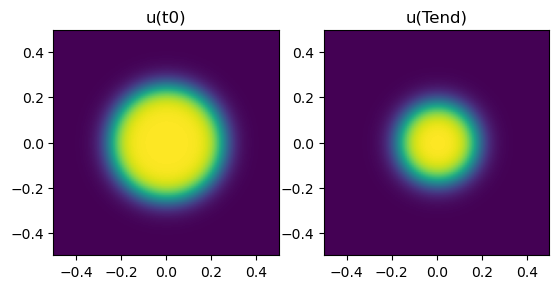

In [6]:
import matplotlib.pylab as plt

plt.subplot(1, 2, 1)
plt.title("u(t0)")
plt.imshow(uinit,extent=[-0.5,0.5,-0.5,0.5])

plt.subplot(1, 2, 2)
plt.title("u(Tend)")
plt.imshow(uend,extent=[-0.5,0.5,-0.5,0.5])

We hopefully see that the circle of the 1 phase has shrunk over time as expected.

Now let's have a look at the iteration counts. For this, the ``run`` method also returned a ``stats`` object. 
This is a dictionary where the keys are objects of a custom class and the items are the values we recorded.
We best use the built-in functions to extract what we want from this.

The `get_sorted` function will return a list of tuples which carry in the first entry the value by which we sorted and in the second entry the value of the `type` we wanted.

In [7]:
from pySDC.helpers.stats_helper import get_sorted

# convert filtered statistics to list of iterations count, sorted by time
iter_counts = get_sorted(stats, type='niter', sortby='time')

In [8]:
import numpy as np

# use list comprehension to extract only the values and not when they where recorded
niters = np.array([item[1] for item in iter_counts])

print(f'Mean number of iterations: {np.mean(niters):4.2f}')
print(f'Range of values for number of iterations: {np.ptp(niters)}')
print(f'Position of max/min number of iterations: {int(np.argmax(niters))} / {int(np.argmin(niters))}')
print(f'Iteration count nonlinear solver (sum/mean per call): {prob.newton_itercount} / {prob.newton_itercount / max(prob.newton_ncalls, 1)}')

Mean number of iterations: 5.03
Range of values for number of iterations: 1
Position of max/min number of iterations: 0 / 1
Iteration count nonlinear solver (sum/mean per call): 749 / 1.1630434782608696


We also get the time-to-solution back:

In [9]:
timing = get_sorted(stats, type='timing_run')

print('Time to solution: %6.4f sec.' % timing[0][1])

Time to solution: 6.2692 sec.


More user output - using hooks
------------------------------

The default output can be controlled using the ``logger_level`` in the ``controller_params``: ``30`` shows only warnings, ``20`` gives runtime information, ``15`` gives more detailed runtime information and ``10`` is for debugging. Note that when changing any of these parameters, it is required to set up the controller again, because only then the parameters will be correctly applied everywhere. We will do that later.

In [10]:
controller_params['logger_level'] = 30

Without further specification, ``pySDC`` gathers information on iterations, residuals, runtimes and so on. In order to get problem-specific, custom data in there, hook-classes can be added to the controller, which contain functions that are called whenever certain parts of the algorithm are started or completed. A list of possible functions can be found in ``core/Hooks.py``, which is the class all custom hook-classes should inherit from. We show here an example, where after each step the current radius of the 1 phase is calculated:

In [11]:
from pySDC.core.Hooks import hooks

class monitor(hooks):

    def post_step(self, step, level_number):
        """
        Record the radius.
        
        Args:
            step (pySDC.Step.step): The current step
            level_number (int): Index of the current level
        """
        super().post_step(step, level_number)

        # get current level
        lvl = step.levels[level_number]

        # compute radius
        c = np.count_nonzero(lvl.uend >= 0.0)
        radius = np.sqrt(c / np.pi) * lvl.prob.dx

        # add the radius to the stats object with a key recording the current meta data
        self.add_to_stats(process=step.status.slot, time=lvl.time + lvl.dt, level=level_number, iter=step.status.iter,
                          sweep=lvl.status.sweep, type='computed_radius', value=radius)

Besides some computation, the key functionality is the call to ``self.add_to_stats`` which is the function to add information to the ``stats``-object. Using ``type``, this can later be accessed as we have seen above with ``timing_run`` and ``niter``. The name ``post_step`` of the class function indicates that this will be called after each time-step is completed.

This class can now be added to the controller.
Notice that we reinstatiate the controller as mentioned above such that the new parameters take effect.

In [12]:
controller_params['hook_class'] = monitor
controller = controller_nonMPI(num_procs=1, controller_params=controller_params, description=description)

If you want to record many different values, you can add them all to one hook or supply a list of hook classes to the controller.

We now re-run the simulation, obtain the radius after each step and plot it:

In [13]:
uend, stats = controller.run(u0=uinit, t0=t0, Tend=Tend)

Text(0, 0.5, '$r$')

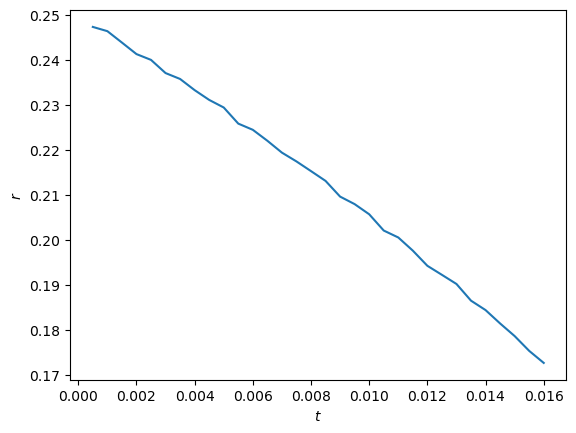

In [14]:
radii = get_sorted(stats, type='computed_radius', sortby='time')

ax = plt.subplot()
ax.plot([t[0] for t in radii], [t[1] for t in radii])
ax.set_xlabel('$t$')
ax.set_ylabel('$r$')

And now you how to run and analyze problems with pySDC!
As a user, your default entry are perhaps problem implementations.
To see how this works, please move on the second notebook!